# 客户画像复赛 数据处理---04&05&10&11&12表特征提取

In [1]:
!ls Data_Update/train/

01_arc_s_95598_wkst_train.tsv  06_cont_info.tsv		11_c_meter.tsv
02_s_comm_rec.tsv	       07_c_rca_cons.tsv	12_a_pay_flow.tsv
03_s_info_oversee.tsv	       08_a_rcved_flow.tsv	out
04_c_cons.tsv		       09_arc_a_rcvbl_flow.tsv	train_label.csv
05_c_cons_prc.tsv	       10_c_meter_read.tsv


## 1 导入必要的包和函数

In [1]:
%pdb 1
debug = 1
import pandas as pd
import numpy as np
import pickle
import re
import io 
import matplotlib.pyplot as plt
%matplotlib inline

# 加载预定义好的函数
# 预定义好的函数：
#    - load_data(file_name, header=0): 加载数据
#    - def show_attribute_detail( data=None, attribute_name=None): 显示数据某个属性的详情
%run data_util_func.py
# 选择过滤方案
PLAN_TYPE = 3

Automatic pdb calling has been turned ON


In [34]:
%who_ls

['FeatureEncoder',
 'data01_appno_contenttype_rdd',
 'data_feature_encoder',
 'debug',
 'extend_train_data',
 'get_accept_content_type',
 'get_highest_sensitive_workerid',
 'get_metrics',
 'io',
 'is_highest_sensitive_worker_dict',
 'load_data',
 'model_predict',
 'model_train',
 'np',
 'pd',
 'pickle',
 'plt',
 'print_function',
 're',
 'save_data',
 'seperate_data_to_classifier',
 'show_attribute_detail',
 'show_df_info',
 'test_data01_df',
 'test_data01_merge_label_df',
 'test_data_labels_df',
 'train_accept_content_type_count_df',
 'train_accept_content_type_sensitive_rate_series',
 'train_custno_in_season4_count_dict',
 'train_custno_in_season4_count_rdd',
 'train_custno_search_action_count_dict',
 'train_custno_search_action_count_rdd',
 'train_data01_a_worker_per_user',
 'train_data01_a_worker_per_user_accept_content_type_count_df',
 'train_data01_custno_handle_month_rdd',
 'train_data01_custno_issearchaction_rdd',
 'train_data01_merge_label_df',
 'train_data01_user_worker_count

In [36]:
del test_data_labels_df

##  2 加载数据 

---------
## 3 实收电费信息表 和 应收电费信息表  09_ARC_A_RCVBL_FLOW - 特征探索

### 3-15 04表 用电客户信息表 04_c_cons

#### 2-1-1 训练集

##### 2-1-1-1  加载数据 train/04_c_cons.tsv

In [2]:
%%time
# 要特别注意 统一设置 converters={0:unicode}，
# 避免后面连接错误
train_data04_df = load_data(file_name = 'Data_Update/train/04_c_cons.tsv',
                                 converters={'CONS_ID':unicode,'CONS_NO':unicode}
                                )
# 记录数 1968846
print(train_data04_df.shape)
# 用户数 656282
print(len(train_data04_df['CONS_ID'].unique()))

/usr/local/lib/python2.7/dist-packages/IPython/core/magic.py:188: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


(1968846, 12)
656282
CPU times: user 8.01 s, sys: 700 ms, total: 8.71 s
Wall time: 8.93 s


##### 2-4-1-2 将数据连接上标签 

In [3]:
%%time
# 连接上的用户都是敏感的 ，置为1，有 542,218 个 data08记录， 45,659个用户
train_data04_merge_label_df = train_data04_df.merge(
    train_data_labels_df,
    how='left',
    left_on='CONS_NO',
    right_on='CUST_NO'
)
# 将没有连接上的工单设置为不敏感用户，  2,707,524 个 data08记录,236,493个用户
train_data04_merge_label_df['TAG'] = train_data04_merge_label_df['TAG'].fillna(0)
train_data04_merge_label_df['TAG'] = train_data04_merge_label_df['TAG'].astype(int)

NameError: name 'train_data_labels_df' is not defined

> <timed exec>(3)<module>()

ipdb> q


In [90]:
# 两个一一对应
train_data04_merge_label_df[['CONS_NO','CONS_ID']].drop_duplicates().shape

(656282, 2)

###### 输出 训练集中 CONS_NO','CONS_ID'

In [ ]:
train_data04_cust_no_cons_id_tag_df = \
    train_data04_merge_label_df[['CONS_NO','CONS_ID','TAG']].drop_duplicates().sort_values(by='TAG')
save_data(
    train_data04_cust_no_cons_id_tag_df,
    'train_data04_cust_no_cons_id_tag_df.csv'
)
train_data04_cust_no_cons_id_tag_df.shape

###### 从文件中恢复

In [5]:
# CONS_NO 全部转为字符串，否则在连接表的时候会出问题
train_data01_cust_no_tag_df = load_data('train_data01_cust_no_tag_df.csv',
                                        encoding='utf8',
                                        converters={'CUST_NO':unicode}
                                       )

In [ ]:
sa

In [8]:
show_df_info(train_data04_merge_label_df)

       CONS_ID     CONS_NO                     ELEC_ADDR TRADE_CODE  \
0  17747484982  6023090135   浙江省杭州市江干区九堡镇兴安社区九洲芳园2幢2****       9910   
1  17747484987  6023090140   浙江省杭州市江干区九堡镇兴安社区九洲芳园2幢2****       9910   
2  17747484992  6023090145   浙江省杭州市江干区九堡镇兴安社区九洲芳园2幢2****       9910   
3  17694250067  6023084488  浙江省杭州市江干区九堡镇杨公社区江岸邻里小区8幢****       9910   
4  17851227583  6023107736   浙江省杭州市江干区彭埠镇建华社区建华家苑2幢3****       9910   

   ELEC_TYPE_CODE  CONTRACT_CAP  LODE_ATTR_CODE  HEC_INDUSTRY_CODE  \
0             202           8.0             3.0                NaN   
1             202           8.0             3.0                NaN   
2             202           8.0             3.0                NaN   
3             202           8.0             3.0                NaN   
4             202           8.0             3.0                NaN   

   STATUS_CODE       ORG_NO  CONS_SORT_CODE  URBAN_RURAL_FLAG CUST_NO  TAG  
0            0  33401010141               3               1.0     NaN    0 

In [9]:
train_data04_merge_label_df.head()

,CONS_ID,CONS_NO,ELEC_ADDR,TRADE_CODE,ELEC_TYPE_CODE,CONTRACT_CAP,LODE_ATTR_CODE,HEC_INDUSTRY_CODE,STATUS_CODE,ORG_NO,CONS_SORT_CODE,URBAN_RURAL_FLAG,CUST_NO,TAG
0,17747484982,6023090135,浙江省杭州市江干区九堡镇兴安社区九洲芳园2幢2****,9910,202,8.0,3.0,NaN,0,33401010141,3,1.0,NaN,0
1,17747484987,6023090140,浙江省杭州市江干区九堡镇兴安社区九洲芳园2幢2****,9910,202,8.0,3.0,NaN,0,33401010141,3,1.0,NaN,0
2,17747484992,6023090145,浙江省杭州市江干区九堡镇兴安社区九洲芳园2幢2****,9910,202,8.0,3.0,NaN,0,33401010141,3,1.0,NaN,0
3,17694250067,6023084488,浙江省杭州市江干区九堡镇杨公社区江岸邻里小区8幢****,9910,202,8.0,3.0,NaN,0,33401010141,3,1.0,NaN,0
4,17851227583,6023107736,浙江省杭州市江干区彭埠镇建华社区建华家苑2幢3****,9910,202,8.0,3.0,NaN,0,33401010141,3,1.0,NaN,0


###### 统计 敏感和 不敏感 分布情况

(2,)


0    1728771
1     240075
Name: TAG, dtype: int64

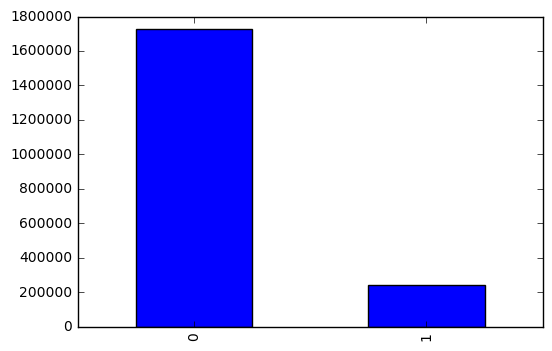

In [29]:
# 所有记录
show_attribute_detail(
    train_data04_merge_label_df,
    'TAG'
)

(2,)


0    576257
1     80025
Name: TAG, dtype: int64

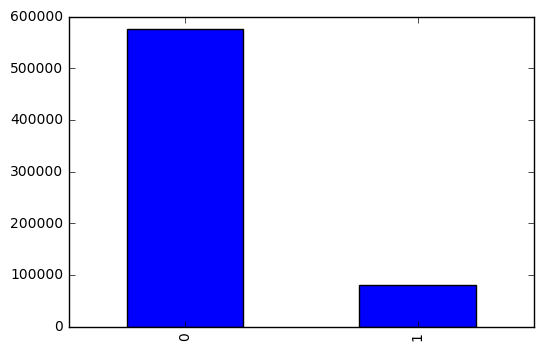

In [30]:
show_attribute_detail(
    train_data04_merge_label_df[['CONS_NO','TAG']].drop_duplicates(),
    'TAG'
)

##### 和data01数据的用户列表比较

In [32]:
train_data01_data04_cust_no_tag_df = train_data01_a_worker_per_user.merge(
    train_data04_merge_label_df[['CONS_NO','TAG']].drop_duplicates(),
    how='outer',
    left_on='CUST_NO',
    right_on='CONS_NO'
)
# 合并所有用户有：658374   ----  跟表1一样，即 表4中所有用户都在表1中
# 在data01数据中，而不在data08数据中的用户数有：0
# 在data08数据中，而不在data01数据中的用户数有：376222
print '合并所有用户有：%d'%train_data01_data04_cust_no_tag_df.shape[0]
print '在data04数据中，而不在data01数据中的用户数有：%d'%sum(train_data01_data04_cust_no_tag_df['CUST_NO'].isnull())
print '在data01数据中，而不在data04数据中的用户数有：%d'%sum(train_data01_data04_cust_no_tag_df['CONS_NO'].isnull())


合并所有用户有：658374
在data04数据中，而不在data01数据中的用户数有：0
在data01数据中，而不在data04数据中的用户数有：2092


In [35]:
train_data04_merge_label_df.head()

,CONS_ID,CONS_NO,ELEC_ADDR,TRADE_CODE,ELEC_TYPE_CODE,CONTRACT_CAP,LODE_ATTR_CODE,HEC_INDUSTRY_CODE,STATUS_CODE,ORG_NO,CONS_SORT_CODE,URBAN_RURAL_FLAG,CUST_NO,TAG
0,17747484982,6023090135,浙江省杭州市江干区九堡镇兴安社区九洲芳园2幢2****,9910,202,8.0,3.0,NaN,0,33401010141,3,1.0,NaN,0
1,17747484987,6023090140,浙江省杭州市江干区九堡镇兴安社区九洲芳园2幢2****,9910,202,8.0,3.0,NaN,0,33401010141,3,1.0,6023090140,1
2,17747484992,6023090145,浙江省杭州市江干区九堡镇兴安社区九洲芳园2幢2****,9910,202,8.0,3.0,NaN,0,33401010141,3,1.0,NaN,0
3,17694250067,6023084488,浙江省杭州市江干区九堡镇杨公社区江岸邻里小区8幢****,9910,202,8.0,3.0,NaN,0,33401010141,3,1.0,NaN,0
4,17851227583,6023107736,浙江省杭州市江干区彭埠镇建华社区建华家苑2幢3****,9910,202,8.0,3.0,NaN,0,33401010141,3,1.0,NaN,0


In [61]:
train_data04_merge_label_df['LODE_ATTR_CODE'].unique()

array([  3.,   2.,   1.,  nan])

In [62]:
train_data04_merge_label_df[['ORG_NO','LODE_ATTR_CODE']].drop_duplicates()

,ORG_NO,LODE_ATTR_CODE
0,33401010141,3.0
48,33401010129,3.0
51,33401010140,3.0
320,33401010141,2.0
592,33401010141,1.0
702,33401010140,NaN
1049,33401010140,2.0
1309,33401010128,NaN
1336,33401010129,NaN
2006,33401010130,NaN


In [66]:
show_attribute_detail(
    train_data04_merge_label_df,
    'LODE_ATTR_CODE',
    True,
    'URBAN_RURAL_FLAG'
)

TypeError: %d format: a number is required, not numpy.float64

> /home/jdwang/PycharmProjects/customerPortrait/semi-finals/data_util_func.py(166)show_attribute_detail()
    164         for tag_value in data[tag_name].unique():
    165             tag1 = data.loc[data[tag_name] == tag_value, attribute_name].value_counts().sort_index()
--> 166             temp['tag%d' % tag_value] = tag1
    167             temp['tag%d/total' % tag_value] = tag1 / total
    168             # print(tag_value)

ipdb> q


### 3-15 11表 运行电能信息表 11_C_METER

#### 2-1-1 训练集

##### 2-1-1-1  加载数据 train/11_c_meter.tsv

In [83]:
%%time
# 要特别注意 统一设置 converters={0:unicode}，
# 避免后面连接错误
train_data11_df = load_data(file_name = 'Data_Update/train/11_c_meter.tsv',
                                 converters={'CONS_ID':unicode}
                                )
# 记录数 25,807,825
print(train_data11_df.shape)
# 用户数 25,622,658
print(len(train_data11_df['CONS_ID'].unique()))

/usr/local/lib/python2.7/dist-packages/IPython/core/magic.py:188: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


(25807825, 6)
25622658
CPU times: user 50 s, sys: 4.45 s, total: 54.5 s
Wall time: 1min 17s


In [87]:
len(train_data04_merge_label_df['CONS_ID'].unique())

656282

##### 2-4-1-2 将数据连接上标签 

In [ ]:
%%time
# 连接上的用户都是敏感的 ，置为1，有 542,218 个 data08记录， 45,659个用户
train_data11_merge_data04_df = train_data11_df.merge(
    train_data04_merge_label_df,
    how='left',
    left_on='CONS_ID',
    right_on='CONS_ID'
)
# 将没有连接上的工单设置为不敏感用户，  2,707,524 个 data08记录,236,493个用户
train_data11_merge_label_df['TAG'] = train_data11_merge_label_df['TAG'].fillna(0)
train_data11_merge_label_df['TAG'] = train_data11_merge_label_df['TAG'].astype(int)

In [84]:
%%time
# 连接上的用户都是敏感的 ，置为1，有 542,218 个 data08记录， 45,659个用户
train_data11_merge_label_df = train_data11_df.merge(
    train_data_labels_df,
    how='left',
    left_on='CONS_ID',
    right_on='CUST_NO'
)
# 将没有连接上的工单设置为不敏感用户，  2,707,524 个 data08记录,236,493个用户
train_data11_merge_label_df['TAG'] = train_data11_merge_label_df['TAG'].fillna(0)
train_data11_merge_label_df['TAG'] = train_data11_merge_label_df['TAG'].astype(int)

CPU times: user 19.6 s, sys: 4.31 s, total: 23.9 s
Wall time: 39.4 s


In [21]:
show_df_info(train_data11_merge_label_df)

     METER_ID     ORG_NO MEAS_BOX  SORT_CODE  TYPE_CODE      CONS_ID CUST_NO  \
0  3002822017  3340101.0      NaN          3       2418  12332601047     NaN   
1  3002821792  3340101.0      NaN          3       2418  12332601015     NaN   
2  3002741739  3340101.0      NaN          3       2418  12332601009     NaN   
3  3002741786  3340101.0      NaN          3       2418  12332601009     NaN   
4  2993895722    33401.0      NaN          3       2418  16531875042     NaN   

   TAG  
0    0  
1    0  
2    0  
3    0  
4    0  


MemoryError: 

> /usr/local/lib/python2.7/dist-packages/numpy/core/shape_base.py(230)vstack()
    228 
    229     """
--> 230     return _nx.concatenate([atleast_2d(_m) for _m in tup], 0)
    231 
    232 def hstack(tup):

ipdb> q


In [22]:
train_data11_merge_label_df.head()

,METER_ID,ORG_NO,MEAS_BOX,SORT_CODE,TYPE_CODE,CONS_ID,CUST_NO,TAG
0,3002822017,3340101.0,NaN,3,2418,12332601047,NaN,0
1,3002821792,3340101.0,NaN,3,2418,12332601015,NaN,0
2,3002741739,3340101.0,NaN,3,2418,12332601009,NaN,0
3,3002741786,3340101.0,NaN,3,2418,12332601009,NaN,0
4,2993895722,33401.0,NaN,3,2418,16531875042,NaN,0


In [15]:
len(train_data11_df['TYPE_CODE'].unique())

55

In [29]:
sum(train_data11_df['CONS_ID']=='12332601047')

84

In [25]:
train_data01_a_worker_per_user['CUST_NO'].head()

0    5720017228
1    7618031763
2    6010466106
3    1658156188
4    3168134368
Name: CUST_NO, dtype: object

In [16]:
train_data11_df['TYPE_CODE'].unique()

array([2418,   86, 2439, 2438, 2433,   85,   84, 2410, 2414,   24, 2429,
       2211,   83, 2412, 2101, 2431, 2417, 2425, 2405, 2415, 2426, 2413,
       1601,   21, 2437, 2210, 2401, 1301, 2202, 2201, 2420, 1101, 2451,
       2436, 2452, 2416, 2445, 2430,   87,   88, 2411, 2432, 2404, 2406,
       2428, 2424, 2103, 2440, 2421, 2434, 2419, 2409,   28, 2402, 2435])

In [ ]:
train_data11_df

(1,)


0    25807825
Name: TAG, dtype: int64

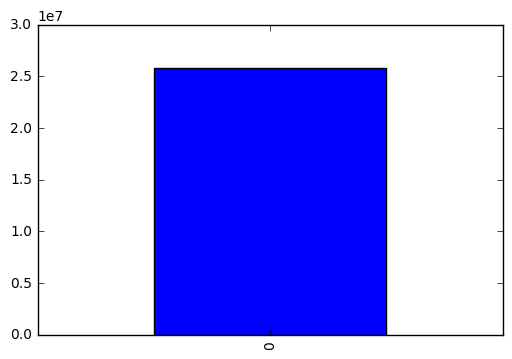

In [23]:
show_attribute_detail(
    train_data11_merge_label_df,
    'TAG',
)

### 3-16 12表 收费记录 12_A_PAY_FLOW

#### 2-1-1 训练集

##### 2-1-1-1  加载数据 train/11_c_meter.tsv

In [68]:
%%time
# 要特别注意 统一设置 converters={0:unicode}，
# 避免后面连接错误
train_data12_df = load_data(file_name = 'Data_Update/train/12_a_pay_flow.tsv',
                                 converters={'CONS_NO':unicode}
                                )
# 记录数 5483788
print(train_data12_df.shape)
# 用户数 431833
print(len(train_data12_df['CONS_NO'].unique()))

(5483788, 5)
431833
CPU times: user 10.4 s, sys: 704 ms, total: 11.1 s
Wall time: 12.6 s


##### 2-4-1-2 将数据连接上标签 

In [69]:
%%time
# 连接上的用户都是敏感的 ，置为1，有 542,218 个 data08记录， 45,659个用户
train_data12_merge_label_df = train_data12_df.merge(
    train_data_labels_df,
    how='left',
    left_on='CONS_NO',
    right_on='CUST_NO'
)
# 将没有连接上的工单设置为不敏感用户，  2,707,524 个 data08记录,236,493个用户
train_data12_merge_label_df['TAG'] = train_data12_merge_label_df['TAG'].fillna(0)
train_data12_merge_label_df['TAG'] = train_data12_merge_label_df['TAG'].astype(int)

CPU times: user 2.78 s, sys: 192 ms, total: 2.98 s
Wall time: 3.74 s


###### 统计 敏感和 不敏感 分布情况

(2,)


0    4624437
1     859351
Name: TAG, dtype: int64

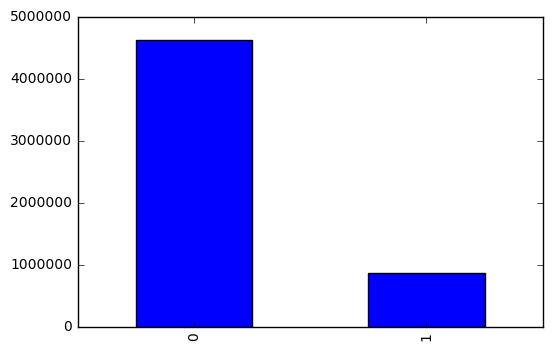

In [70]:
# 所有记录
show_attribute_detail(
    train_data12_merge_label_df,
    'TAG'
)

(2,)


0    366218
1     65615
Name: TAG, dtype: int64

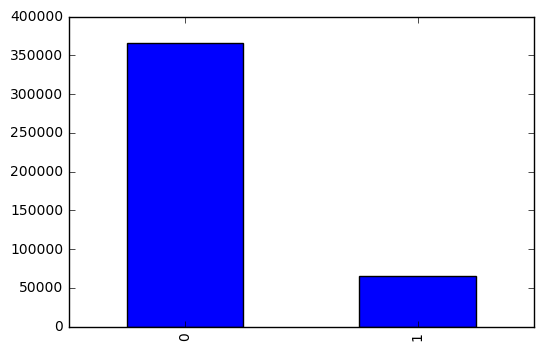

In [76]:
show_attribute_detail(
    train_data12_merge_label_df[['CONS_NO','TAG']].drop_duplicates(),
    'TAG'
)

##### 和data01数据的用户列表比较

In [77]:
train_data01_data12_cust_no_tag_df = train_data01_a_worker_per_user.merge(
    train_data12_merge_label_df[['CONS_NO','TAG']].drop_duplicates(),
    how='outer',
    left_on='CUST_NO',
    right_on='CONS_NO'
)
# 合并所有用户有：658374   ----  跟表1一样，即 表4中所有用户都在表1中
# 在data01数据中，而不在data08数据中的用户数有：0
# 在data08数据中，而不在data01数据中的用户数有：376222
print '合并所有用户有：%d'%train_data01_data12_cust_no_tag_df.shape[0]
print '在data12数据中，而不在data01数据中的用户数有：%d'%sum(train_data01_data12_cust_no_tag_df['CUST_NO'].isnull())
print '在data01数据中，而不在data12数据中的用户数有：%d'%sum(train_data01_data12_cust_no_tag_df['CONS_NO'].isnull())


合并所有用户有：658374
在data12数据中，而不在data01数据中的用户数有：0
在data01数据中，而不在data12数据中的用户数有：226541


In [75]:
sum(train_data01_data12_cust_no_tag_df['CONS_NO'].isnull())

226541

In [81]:
train_data12_merge_label_df['PAY_MODE'].unique()

array([20271, 10101, 20311, 20108, 20101, 30201, 10301, 10601, 10106,
       20331, 20261])

(11, 5)


,total,tag0,tag0/total,tag1,tag1/total
10101,576918,472523,0.819047,104395,0.180953
10106,790,709,0.897468,81,0.102532
10301,14386,12645,0.878980,1741,0.121020
10601,432,355,0.821759,77,0.178241
20101,1359442,1107996,0.815037,251446,0.184963
20108,882857,717343,0.812525,165514,0.187475
20261,80979,65429,0.807975,15550,0.192025
20271,80243,61995,0.772591,18248,0.227409
20311,2033207,1796470,0.883565,236737,0.116435
20331,290576,254387,0.875458,36189,0.124542


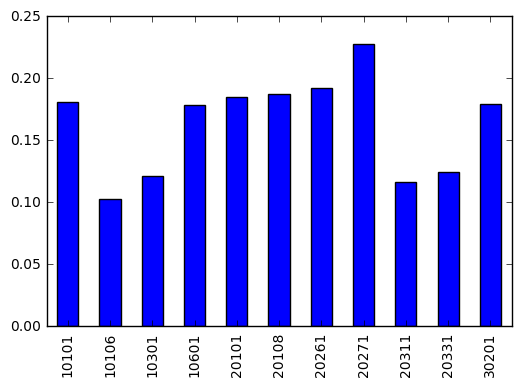

In [82]:
show_attribute_detail(
    train_data12_merge_label_df,
    'PAY_MODE',
    True,
    'TAG'
)

#### 测试集

In [79]:
test_data01_data12_cust_no_tag_df = test_data01_a_worker_per_user.merge(
    train_data12_merge_label_df[['CONS_NO','TAG']].drop_duplicates(),
    how='outer',
    left_on='CUST_NO',
    right_on='CONS_NO'
)
# 无测试集用户
print '合并所有用户有：%d'%test_data01_data12_cust_no_tag_df.shape[0]
print '在data12数据中，而不在data01数据中的用户数有：%d'%sum(test_data01_data12_cust_no_tag_df['CUST_NO'].isnull())
print '在data01数据中，而不在data12数据中的用户数有：%d'%sum(test_data01_data12_cust_no_tag_df['CONS_NO'].isnull())


合并所有用户有：802704
在data12数据中，而不在data01数据中的用户数有：431833
在data01数据中，而不在data12数据中的用户数有：370871
